# Customer analysis in marketing campaigns

In this exercise, you work for a consulting firm as data scientist. In this scenario, your client is the marketing team of a grocery store. They would like to find which are the ideal customers according to the results of the last marketing campaigns. Your analysis will be helpful to adapt and modify products according to the different needs and behavior of their customers.

You dispose of a dataset from the mall dataset with several features:


People

- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if customer complained in the last 2 years, 0 otherwise

Products

- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

Promotion

- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place

- NumWebPurchases: Number of purchases made through the company’s web site
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s web site in the last month

'Z_CostContact' and 'Z_Revenue' contains constant value across all the observations and therefore they will not contribute anything in the analysis.

You have two days to do this study

In [196]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
%matplotlib inline
from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [197]:
df = pd.read_csv('data/marketing_campaign.csv', sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [159]:
df.shape

(2240, 29)

# EDA

In [198]:
# Display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [199]:
# drop columns Z_CostContact & Z_Revenue
df.drop(['Z_CostContact','Z_Revenue'], axis=1, inplace=True)

In [200]:
# convert Year Birth in column Age
df['Age'] = 2014 - df['Year_Birth']
df.drop(['Year_Birth'], axis=1, inplace=True)

In [201]:
# convert Year_Birth & Dt_Customer in datetime
df['Dt_Customer'] = df['Dt_Customer'].apply(pd.to_datetime)

In [202]:
# Marital_Status

# drop some values (2 YOLO / 2 ABSURD / 3 ALONE)
values = ['YOLO', 'Absurd']
df = df[df.Marital_Status.isin(values) == False]

# replace statut ALONE by SINGLE
df = df.replace(['Alone'],'Single')

In [ ]:
# encoding Marital_Status
#df = pd.get_dummies(df, columns=['Marital_Status'], prefix=["Status"])

In [203]:
# remove the outlier in Income
outlier = df['Income'].quantile(0.95)
df = df[df["Income"] < outlier]

In [ ]:
# 0 NaN values
df.isnull().sum().sort_values(ascending=False)

In [204]:
# new features
df['Kid'] = df['Kidhome'] + df['Teenhome']
df['Total expense'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Campaign_OK'] = df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['Response']
df['Purchases total'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [205]:
# drop some columns
df = df.drop(columns=['ID', 'Kidhome', 'Teenhome', 'Dt_Customer', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',  'Complain', 'NumDealsPurchases', 
        'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'NumStorePurchases', 'NumCatalogPurchases','NumWebPurchases'])

In [206]:
# label encoder : marital_status / education
label_encoder = preprocessing.LabelEncoder()
df['Marital_Status']= label_encoder.fit_transform(df['Marital_Status'])
df['Marital_Status'].unique()

df['Education']= label_encoder.fit_transform(df['Marital_Status'])
df['Education'].unique()

array([2, 3, 1, 0, 4], dtype=int64)

# Visualisation

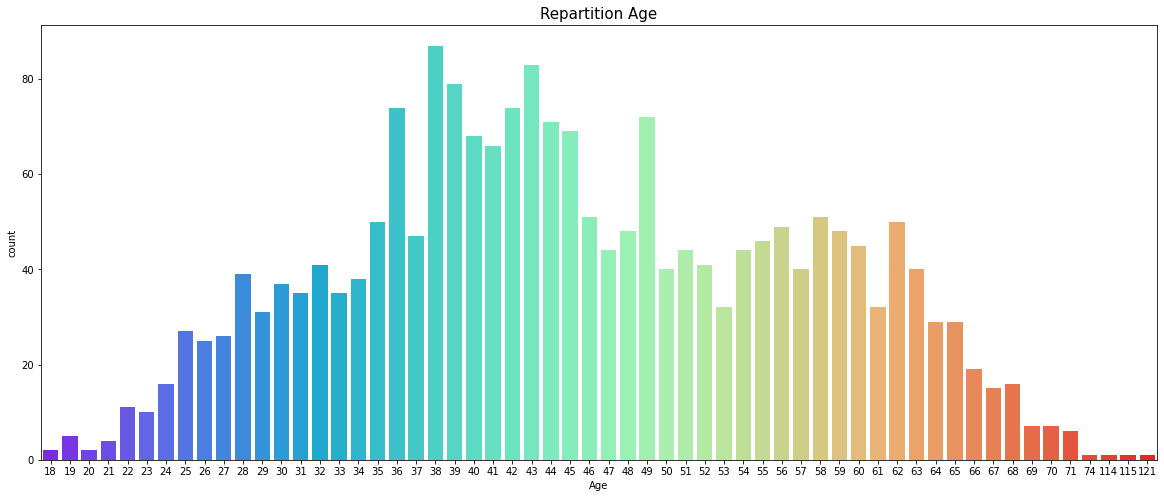

In [197]:
plt.rcParams['figure.figsize'] = (20, 8)
sns.countplot(df['Age'], palette = 'rainbow')
plt.title('Repartition Age', fontsize = 15)
plt.show()

# Customer Segmentation : RFM 

In [8]:
RFM = df

In [9]:
RFM_prep = RFM[['ID','Recency','MntSweetProducts','MntGoldProds','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']]

In [10]:
RFM['Frequency'] = RFM['NumWebPurchases']+RFM['NumCatalogPurchases']+RFM['NumStorePurchases']

In [11]:
RFM['Monetary'] =  RFM['MntFishProducts']+RFM['MntFruits']+RFM['MntWines']+RFM['MntSweetProducts']+RFM['MntGoldProds']+RFM['MntMeatProducts']

In [284]:
df_RFM

,ID,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Complain,Response,Age,Status_Divorced,Status_Married,Status_Single,Status_Together,Status_Widow,Frequency,Monetary
0,5524,Graduation,58138.0,0,0,2012-04-09,58,635,88,546,...,0,1,57,0,0,1,0,0,22,1617
1,2174,Graduation,46344.0,1,1,2014-08-03,38,11,1,6,...,0,0,60,0,0,1,0,0,4,27
2,4141,Graduation,71613.0,0,0,2013-08-21,26,426,49,127,...,0,0,49,0,0,0,1,0,20,776
3,6182,Graduation,26646.0,1,0,2014-10-02,26,11,4,20,...,0,0,30,0,0,0,1,0,6,53
4,5324,PhD,58293.0,1,0,2014-01-19,94,173,43,118,...,0,0,33,0,1,0,0,0,14,422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,Graduation,61223.0,0,1,2013-06-13,46,709,43,182,...,0,0,47,0,1,0,0,0,16,1341
2236,4001,PhD,64014.0,2,1,2014-10-06,56,406,0,30,...,0,0,68,0,0,0,1,0,15,444
2237,7270,Graduation,56981.0,0,0,2014-01-25,91,908,48,217,...,0,0,33,1,0,0,0,0,18,1241
2238,8235,Master,69245.0,0,1,2014-01-24,8,428,30,214,...,0,0,58,0,0,0,1,0,21,843


In [285]:
# Recency : 15 jours / au dela de 20 jours et 2 mois / 2 mois et plus
# Fréquence: 30> / entre 20 et 8 / inférieur a 8
# Montant : >900, 300 et 900,  <300 / niveau 1/2

In [12]:
def r_score (r):
    if r <= RFM['Recency'][15]:
        return 3
    elif r >= RFM['Recency'][60]:
        return 1
    else:
        return 2
    
def f_score (f):
    if f <= RFM['Frequency'][8]:
        return 1
    elif f >= RFM['Frequency'][30]:
        return 3
    else:
        return 2
    
def m_score (m):
    if m <= RFM['Monetary'][300]:
        return 1
    elif m >= RFM['Monetary'][1500]:
        return 3
    else:
        return 2

In [13]:
RFM['M'] = RFM['Monetary'].apply(lambda x: m_score(x))
RFM['F'] = RFM['Frequency'].apply(lambda x: f_score(x))
RFM['R'] = RFM['Recency'].apply(lambda x: r_score(x))

In [18]:
RFM['RFM Score'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
RFM.head()

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,AcceptedCmp2,Complain,Response,Age,Frequency,Monetary,M,F,R,RFM Score
0,5524,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,...,0,0,1,57,22,1617,3,3,1,133
1,2174,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,...,0,0,0,60,4,27,1,1,1,111
2,4141,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,0,0,0,49,20,776,3,3,1,133
3,6182,Graduation,Together,26646.0,1,0,2014-10-02,26,11,4,...,0,0,0,30,6,53,1,3,1,131
4,5324,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,0,0,0,33,14,422,2,3,1,132


In [19]:
def categ(x):
    if x in["333"]:
        return "Premium"
    elif x in["233", "232", "133", "332"]:
         return "Fidèle"
    elif x in["132", "311"]:
        return "Dormeur"
    elif x in["122", "111"]:
         return "Lost"
    elif x in["231", "221", "131", "311"]:
         return "Touriste"
    else:
        return "Lambda"

In [20]:
# make dataframe with "Customer Status" column
RFM['Customer Status'] = RFM['RFM Score'].apply(categ)
RFM.head()

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,Complain,Response,Age,Frequency,Monetary,M,F,R,RFM Score,Customer Status
0,5524,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,...,0,1,57,22,1617,3,3,1,133,Fidèle
1,2174,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,...,0,0,60,4,27,1,1,1,111,Lost
2,4141,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,0,0,49,20,776,3,3,1,133,Fidèle
3,6182,Graduation,Together,26646.0,1,0,2014-10-02,26,11,4,...,0,0,30,6,53,1,3,1,131,Touriste
4,5324,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,0,0,33,14,422,2,3,1,132,Dormeur


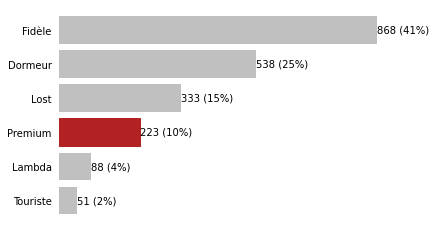

In [21]:
# count the number of customers in each segment
categ_counts = RFM['Customer Status'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(categ_counts)),
              categ_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(categ_counts)))
ax.set_yticklabels(categ_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if categ_counts.index[i] in ['Premium']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/categ_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [22]:
view = RFM[RFM["Customer Status"] == 'Lambda']
view

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,Complain,Response,Age,Frequency,Monetary,M,F,R,RFM Score,Customer Status
35,10738,Master,Single,49389.0,1,1,2013-08-29,55,40,0,...,0,0,63,5,65,2,1,1,112,Lambda
38,8595,Graduation,Widow,42429.0,0,1,2014-11-02,99,55,0,...,0,0,41,5,67,2,1,1,112,Lambda
52,1331,Graduation,Single,35790.0,1,0,2013-02-01,54,12,6,...,0,0,37,5,72,2,1,1,112,Lambda
97,11100,Graduation,Divorced,51813.0,1,1,2013-11-04,37,51,2,...,0,0,42,5,63,2,1,1,112,Lambda
100,1473,2n Cycle,Single,47823.0,0,1,2013-07-23,0,53,1,...,0,0,54,5,72,2,1,3,312,Lambda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,6507,Graduation,Single,30828.0,1,0,2013-04-10,16,16,11,...,0,0,34,6,56,1,3,3,331,Lambda
2124,2115,Graduation,Together,50116.0,1,1,2014-06-20,68,54,0,...,0,0,57,5,66,2,1,1,112,Lambda
2133,642,Basic,Married,16005.0,1,0,2012-08-14,69,1,3,...,0,0,34,5,103,2,1,1,112,Lambda
2204,1876,Graduation,Married,18929.0,0,0,2013-02-16,15,32,0,...,0,0,24,5,85,2,1,3,312,Lambda


# Customer Segmentation  : KMEANS

In [209]:
df_k = df

In [ ]:
# specify columns to scale
col_names = ['Income', 'Recency','Age', 'Total expense', 'Purchases total']
features = df_k[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

#introducing scaled values to df
df_k[col_names] = features
df_k

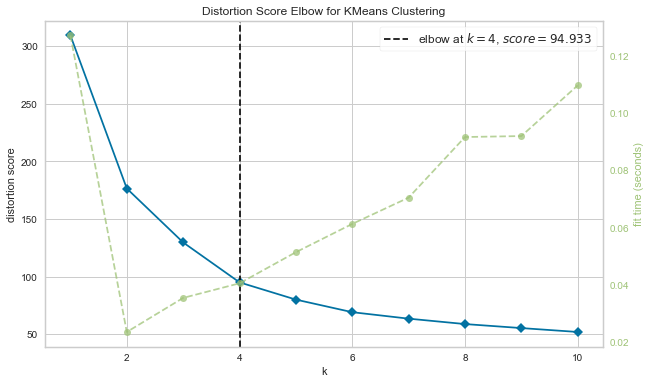

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [147]:
# define features
X_K1 = df_k[['Age', 'Recency', 'Purchases total']]

#plot elbow
plt.figure(figsize=(10,6))
model_km = KMeans(random_state=4)
visualizer = KElbowVisualizer(model_km, k =(1,11))
visualizer.fit(X_K1)
visualizer.show()

In [148]:
# define cluster
model = KMeans(n_clusters=4)

# fit
pred = model.fit_predict(X_K1)

# silhouette score
silhouette_score(X_K1, pred)

0.349804228080058

In [149]:
# new column "cluster" in dataset df_k1
df_k1 = df_k
df_k1['cluster']= pred

In [151]:
# visualisation K-Means
fig = px.scatter_3d(df_k1, x="Age", y="Recency", z="Purchases total", color ='cluster')
fig.show()

# Customer Segmentation : DBSCAN

In [210]:
# define dataset
df_db = df
X = df_db

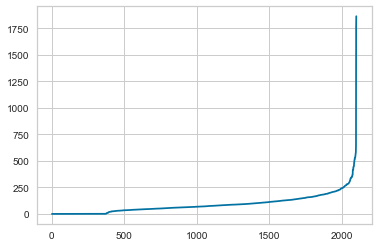

In [211]:
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);

In [213]:
# define dataset
X = df_db

# define the model
model = DBSCAN(eps=250, min_samples=2)

# fit the model
pred = model.fit_predict(X)

# silhouette score
silhouette_score(X, pred)

-0.2902929025111655